# Лабораторная работа №3: Решающее дерево (Decision Tree)


## Цель работы

Изучение алгоритма решающего дерева для решения задач классификации и регрессии на примере прогнозирования успешности фильмов.


## Задачи

1. **Классификация**: Прогнозирование коммерческого успеха фильма

2. **Регрессия**: Прогнозирование зрительского рейтинга фильма


### Целевые переменные:

- **Коммерческий успех**: Бинарная переменная (1 - успешный, 0 - неуспешный)

- **Зрительский рейтинг**: Непрерывная переменя (0-9.1)

# Импорт необходимых библиотек

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
pd.set_option('display.max_columns', None)

# Реализация решающего дерева

In [8]:
class CustomDecisionTreeClassifier:
    def __init__(self, 
                 max_depth=None,
                 min_samples_split=2,
                 criterion='gini',
                 random_state=42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.random_state = random_state
        self.tree = None
        self.feature_importances_ = None
        self.n_features_ = None
        self.n_classes_ = None
        
    def _gini_impurity(self, y):
        if len(y) == 0:
            return 0.0
        
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def _entropy(self, y):
        if len(y) == 0:
            return 0.0
        
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        probabilities = probabilities[probabilities > 0]
        return -np.sum(probabilities * np.log2(probabilities))
    
    def _information_gain(self, parent_y, left_y, right_y):
        n = len(parent_y)
        if n == 0:
            return 0.0
        
        if self.criterion == 'gini':
            parent_impurity = self._gini_impurity(parent_y)
            left_impurity = self._gini_impurity(left_y)
            right_impurity = self._gini_impurity(right_y)
        else:
            parent_impurity = self._entropy(parent_y)
            left_impurity = self._entropy(left_y)
            right_impurity = self._entropy(right_y)
        
        weighted_child_impurity = (len(left_y) * left_impurity + len(right_y) * right_impurity) / n
        
        return parent_impurity - weighted_child_impurity
    
    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        for feature in range(n_features):
            values = X[:, feature]
            unique_values = np.unique(values)
            
            for i in range(len(unique_values) - 1):
                threshold = (unique_values[i] + unique_values[i + 1]) / 2
                
                left_mask = values <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                left_y = y[left_mask]
                right_y = y[right_mask]
                
                gain = self._information_gain(y, left_y, right_y)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           len(np.unique(y)) == 1:
            unique_classes, counts = np.unique(y, return_counts=True)
            return int(unique_classes[np.argmax(counts)])
        
        best_feature, best_threshold, best_gain = self._best_split(X, y)
        
        if best_feature is None or best_gain <= 0:
            unique_classes, counts = np.unique(y, return_counts=True)
            return int(unique_classes[np.argmax(counts)])
        
        node = {
            'feature': best_feature,
            'threshold': best_threshold,
            'gain': best_gain,
            'left': None,
            'right': None
        }
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        if self.feature_importances_ is not None:
            self.feature_importances_[best_feature] += best_gain * n_samples
        
        node['left'] = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node['right'] = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return node
    
    def _predict_sample(self, x, node):
        if isinstance(node, (int, np.integer)):
            return node
        
        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        else:
            return self._predict_sample(x, node['right'])
    
    def fit(self, X, y):
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        y_array = y.values if hasattr(y, 'values') else np.array(y)
        
        if X_array.shape[0] != len(y_array):
            raise ValueError("Количество примеров в X и y должно совпадать")
        
        self.n_features_ = X_array.shape[1]
        self.feature_importances_ = np.zeros(self.n_features_)
        
        self.n_classes_ = len(np.unique(y_array))
        
        np.random.seed(self.random_state)
        
        self.tree = self._build_tree(X_array, y_array)
        
        total_gain = np.sum(self.feature_importances_)
        if total_gain > 0:
            self.feature_importances_ /= total_gain
        
        return self
    
    def predict(self, X):
        if self.tree is None:
            raise ValueError("Модель не обучена. Сначала вызовите fit().")
        
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        return np.array([self._predict_sample(x, self.tree) for x in X_array])
    
    def predict_proba(self, X):
        predictions = self.predict(X)
        probabilities = np.zeros((len(predictions), self.n_classes_))
        
        for i, pred in enumerate(predictions):
            probabilities[i, pred] = 1.0
        
        return probabilities
    
    def score(self, X, y):
        y_pred = self.predict(X)
        y_true = y.values if hasattr(y, 'values') else y
        return np.mean(y_true == y_pred)
    
    def get_depth(self):
        def get_node_depth(node, depth=0):
            if isinstance(node, (int, np.integer)):
                return depth
            
            if isinstance(node, dict):
                left_depth = get_node_depth(node['left'], depth + 1)
                right_depth = get_node_depth(node['right'], depth + 1)
                return max(left_depth, right_depth)
            
            return depth
        
        return get_node_depth(self.tree) if self.tree else 0
    
    def get_n_leaves(self):
        def count_leaves(node):
            if isinstance(node, (int, np.integer)):
                return 1
            
            if isinstance(node, dict):
                return count_leaves(node['left']) + count_leaves(node['right'])
            
            return 0
        
        return count_leaves(self.tree) if self.tree else 0


class CustomDecisionTreeRegressor:
    def __init__(self, 
                 max_depth=None,
                 min_samples_split=2,
                 criterion='squared_error',
                 random_state=42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.random_state = random_state
        self.tree = None
        self.feature_importances_ = None
        self.n_features_ = None
        
    def _mse(self, y):
        if len(y) == 0:
            return 0.0
        mean_y = np.mean(y)
        return np.mean((y - mean_y) ** 2)
    
    def _mae(self, y):
        if len(y) == 0:
            return 0.0
        median_y = np.median(y)
        return np.mean(np.abs(y - median_y))
    
    def _reduction_in_impurity(self, parent_y, left_y, right_y):
        n = len(parent_y)
        if n == 0:
            return 0.0
        
        if self.criterion == 'squared_error':
            parent_impurity = self._mse(parent_y)
            left_impurity = self._mse(left_y)
            right_impurity = self._mse(right_y)
        else:
            parent_impurity = self._mae(parent_y)
            left_impurity = self._mae(left_y)
            right_impurity = self._mae(right_y)
        
        weighted_child_impurity = (len(left_y) * left_impurity + len(right_y) * right_impurity) / n
        
        return parent_impurity - weighted_child_impurity
    
    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        for feature in range(n_features):
            values = X[:, feature]
            unique_values = np.unique(values)
            
            for i in range(len(unique_values) - 1):
                threshold = (unique_values[i] + unique_values[i + 1]) / 2
                
                left_mask = values <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                left_y = y[left_mask]
                right_y = y[right_mask]
                
                gain = self._reduction_in_impurity(y, left_y, right_y)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split:
            return float(np.mean(y))
        
        if len(np.unique(y)) == 1:
            return float(y[0])
        
        best_feature, best_threshold, best_gain = self._best_split(X, y)
        
        if best_feature is None or best_gain <= 0:
            return float(np.mean(y))
        
        node = {
            'feature': best_feature,
            'threshold': best_threshold,
            'gain': best_gain,
            'left': None,
            'right': None
        }
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        if self.feature_importances_ is not None:
            self.feature_importances_[best_feature] += best_gain * n_samples
        
        node['left'] = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node['right'] = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return node
    
    def _predict_sample(self, x, node):
        if isinstance(node, (int, float, np.number)):
            return float(node)
        
        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        else:
            return self._predict_sample(x, node['right'])
    
    def fit(self, X, y):
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        y_array = y.values if hasattr(y, 'values') else np.array(y)
        
        if X_array.shape[0] != len(y_array):
            raise ValueError("Количество примеров в X и y должно совпадать")
        
        self.n_features_ = X_array.shape[1]
        self.feature_importances_ = np.zeros(self.n_features_)
        
        np.random.seed(self.random_state)
        
        self.tree = self._build_tree(X_array, y_array)
        
        total_gain = np.sum(self.feature_importances_)
        if total_gain > 0:
            self.feature_importances_ /= total_gain
        
        return self
    
    def predict(self, X):
        if self.tree is None:
            raise ValueError("Модель не обучена. Сначала вызовите fit().")
        
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        return np.array([self._predict_sample(x, self.tree) for x in X_array])
    
    def score(self, X, y):
        y_pred = self.predict(X)
        y_true = y.values if hasattr(y, 'values') else y
        
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        
        if ss_tot == 0:
            return 0.0
        
        return 1 - (ss_res / ss_tot)
    
    def get_depth(self):
        def get_node_depth(node, depth=0):
            if isinstance(node, (int, float, np.number)):
                return depth
            
            if isinstance(node, dict):
                left_depth = get_node_depth(node['left'], depth + 1)
                right_depth = get_node_depth(node['right'], depth + 1)
                return max(left_depth, right_depth)
            
            return depth
        
        return get_node_depth(self.tree) if self.tree else 0
    
    def get_n_leaves(self):
        def count_leaves(node):
            if isinstance(node, (int, float, np.number)):
                return 1
            
            if isinstance(node, dict):
                return count_leaves(node['left']) + count_leaves(node['right'])
            
            return 0
        
        return count_leaves(self.tree) if self.tree else 0

## 1. Загрузка и изучение данных

In [9]:
def load_and_preprocess_data(dataset_path='./movies_dataset'):
    print(" Загрузка и преобразование данных...")
    
    movies = pd.read_csv(f'{dataset_path}/movies_metadata.csv', low_memory=False)
    print(f"Загружено фильмов: {len(movies)}")
    
    movies_clean = _analyze_target_variables(movies)
    
    movies_processed = _feature_engineering(movies_clean)
    
    X_class, y_class, X_reg, y_reg, features = _create_ml_datasets(movies_processed)
    
    print(" Данные подготовлены для машинного обучения")
    return X_class, y_class, X_reg, y_reg, features

def _analyze_target_variables(movies):
    print("\n Анализ целевых переменных:")
    
    movies_clean = movies.copy()
    movies_clean['revenue'] = pd.to_numeric(movies_clean['revenue'], errors='coerce')
    movies_clean['budget'] = pd.to_numeric(movies_clean['budget'], errors='coerce')
    
    movies_clean = movies_clean[
        (movies_clean['revenue'].notna()) & 
        (movies_clean['budget'].notna()) & 
        (movies_clean['revenue'] > 0) & 
        (movies_clean['budget'] > 0)
    ]
    
    movies_clean['commercial_success'] = (movies_clean['revenue'] > movies_clean['budget'] * 1.5).astype(int)
    
    success_rate = movies_clean['commercial_success'].mean()
    print(f"Доля коммерчески успешных фильмов: {success_rate:.2%}")
    print(f"Количество фильмов для анализа: {len(movies_clean)}")
    
    return movies_clean

def _feature_engineering(movies_clean):
    print("\n Создание признаков:")
    
    numeric_features = ['budget', 'popularity', 'runtime', 'vote_count']
    
    for feature in numeric_features:
        movies_clean[feature] = pd.to_numeric(movies_clean[feature], errors='coerce')
        movies_clean[feature].fillna(movies_clean[feature].median(), inplace=True)
    
    def extract_main_genre(genres_str):
        try:
            if pd.isna(genres_str) or genres_str == '[]':
                return 'Unknown'
            import ast
            genres_list = ast.literal_eval(genres_str)
            if genres_list:
                return genres_list[0]['name']
            return 'Unknown'
        except:
            return 'Unknown'
    
    movies_clean['main_genre'] = movies_clean['genres'].apply(extract_main_genre)
    
    movies_clean['release_date'] = pd.to_datetime(movies_clean['release_date'], errors='coerce')
    movies_clean['release_year'] = movies_clean['release_date'].dt.year
    movies_clean['release_month'] = movies_clean['release_date'].dt.month
    
    movies_clean['release_year'].fillna(movies_clean['release_year'].median(), inplace=True)
    movies_clean['release_month'].fillna(movies_clean['release_month'].median(), inplace=True)
    
    movies_clean['log_budget'] = np.log1p(movies_clean['budget'])
    movies_clean['log_popularity'] = np.log1p(movies_clean['popularity'])
    
    print(" Признаки созданы")
    return movies_clean

def _create_ml_datasets(movies_clean):
    print("\n Подготовка датасетов для ML:")
    
    feature_columns = [
        'budget', 'log_budget', 'popularity', 'log_popularity', 
        'runtime', 'vote_count', 'release_year', 'release_month'
    ]
    
    from sklearn.preprocessing import LabelEncoder
    le_genre = LabelEncoder()
    movies_clean['main_genre_encoded'] = le_genre.fit_transform(movies_clean['main_genre'])
    feature_columns.append('main_genre_encoded')
    
    classification_data = movies_clean[
        (movies_clean['commercial_success'].notna()) & 
        movies_clean[feature_columns].notna().all(axis=1)
    ].copy()
    
    X_classification = classification_data[feature_columns]
    y_classification = classification_data['commercial_success']
    
    print(f" Датасет для классификации: {len(X_classification)} объектов, {len(feature_columns)} признаков")
    
    regression_data = movies_clean[
        (movies_clean['vote_average'].notna()) & 
        movies_clean[feature_columns].notna().all(axis=1)
    ].copy()
    
    X_regression = regression_data[feature_columns]
    y_regression = regression_data['vote_average']
    
    print(f" Датасет для регрессии: {len(X_regression)} объектов, {len(feature_columns)} признаков")
    
    return X_classification, y_classification, X_regression, y_regression, feature_columns

X_class, y_class, X_reg, y_reg, feature_names = load_and_preprocess_data()

print(" Информация о данных:")
print(f"Классификация: {X_class.shape[0]} объектов, {X_class.shape[1]} признаков")
print(f"Регрессия: {X_reg.shape[0]} объектов, {X_reg.shape[1]} признаков")
print(f"\nБаланс классов (классификация): {y_class.value_counts().to_dict()}")
print(f"Статистика рейтинга: мин={y_reg.min():.2f}, макс={y_reg.max():.2f}, среднее={y_reg.mean():.2f}")

 Загрузка и преобразование данных...
Загружено фильмов: 45466

 Анализ целевых переменных:
Доля коммерчески успешных фильмов: 59.43%
Количество фильмов для анализа: 5381

 Создание признаков:
 Признаки созданы

 Подготовка датасетов для ML:
 Датасет для классификации: 5381 объектов, 9 признаков
 Датасет для регрессии: 5381 объектов, 9 признаков
 Данные подготовлены для машинного обучения
 Информация о данных:
Классификация: 5381 объектов, 9 признаков
Регрессия: 5381 объектов, 9 признаков

Баланс классов (классификация): {1: 3198, 0: 2183}
Статистика рейтинга: мин=0.00, макс=9.10, среднее=6.27


### 1.1 Анализ признаков

In [1]:
print(" Описание признаков:")
print(X_class.describe())

print("\n Пропущенные значения:")
print("Классификация:", X_class.isnull().sum().sum())
print("Регрессия:", X_reg.isnull().sum().sum())


 Описание признаков:


NameError: name 'X_class' is not defined

## 2. Подготовка данных для моделирования

In [11]:
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(" Размеры выборок:")
print(f"Классификация - обучающая: {X_class_train.shape[0]}, тестовая: {X_class_test.shape[0]}")
print(f"Регрессия - обучающая: {X_reg_train.shape[0]}, тестовая: {X_reg_test.shape[0]}")

 Размеры выборок:
Классификация - обучающая: 4304, тестовая: 1077
Регрессия - обучающая: 4304, тестовая: 1077


### 2.1 Масштабирование признаков

In [12]:
scaler_class = StandardScaler()
X_class_train_scaled = scaler_class.fit_transform(X_class_train)
X_class_test_scaled = scaler_class.transform(X_class_test)

scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)

print(" Данные подготовлены для моделирования")
print(" Примечание: Деревья решений не требуют масштабирования признаков")

 Данные подготовлены для моделирования
 Примечание: Деревья решений не требуют масштабирования признаков


## 3. Создание бейзлайна и оценка качества

### 3.1 Базовая модель решающего дерева

In [13]:
dt_class_base = DecisionTreeClassifier(random_state=42)
dt_class_base.fit(X_class_train, y_class_train)

y_class_pred_base = dt_class_base.predict(X_class_test)

accuracy_base = accuracy_score(y_class_test, y_class_pred_base)

print(f" Базовая модель классификации:")
print(f"Accuracy: {accuracy_base:.4f}")
print(f"Глубина дерева: {dt_class_base.get_depth()}")
print(f"Количество листьев: {dt_class_base.get_n_leaves()}")

print("\nОтчет классификации:")
print(classification_report(y_class_test, y_class_pred_base))

 Базовая модель классификации:
Accuracy: 0.6787
Глубина дерева: 21
Количество листьев: 840

Отчет классификации:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       437
           1       0.73      0.72      0.73       640

    accuracy                           0.68      1077
   macro avg       0.67      0.67      0.67      1077
weighted avg       0.68      0.68      0.68      1077



In [14]:
dt_reg_base = DecisionTreeRegressor(random_state=42)
dt_reg_base.fit(X_reg_train, y_reg_train)

y_reg_pred_base = dt_reg_base.predict(X_reg_test)

mae_base = mean_absolute_error(y_reg_test, y_reg_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_base))
r2_base = r2_score(y_reg_test, y_reg_pred_base)

print(f" Базовая модель регрессии:")
print(f"MAE: {mae_base:.4f}")
print(f"RMSE: {rmse_base:.4f}")
print(f"R²: {r2_base:.4f}")
print(f"Глубина дерева: {dt_reg_base.get_depth()}")
print(f"Количество листьев: {dt_reg_base.get_n_leaves()}")

 Базовая модель регрессии:
MAE: 0.7095
RMSE: 0.9493
R²: -0.0592
Глубина дерева: 30
Количество листьев: 3761


## 4. Улучшение бейзлайна

### 4.1 Подбор оптимальных параметров

In [15]:
param_grid_class = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

param_grid_reg = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['squared_error', 'absolute_error']
}

print(" Подбор оптимальных параметров для классификации...")

dt_class_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_class,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
dt_class_grid.fit(X_class_train, y_class_train)

print(f"Лучшие параметры классификации: {dt_class_grid.best_params_}")
print(f"Лучший скор (CV): {dt_class_grid.best_score_:.4f}")

 Подбор оптимальных параметров для классификации...


Лучшие параметры классификации: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Лучший скор (CV): 0.7351


In [16]:
print(" Подбор оптимальных параметров для регрессии...")

dt_reg_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
dt_reg_grid.fit(X_reg_train, y_reg_train)

print(f"Лучшие параметры регрессии: {dt_reg_grid.best_params_}")
print(f"Лучший скор (CV): {dt_reg_grid.best_score_:.4f}")

 Подбор оптимальных параметров для регрессии...
Лучшие параметры регрессии: {'criterion': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}
Лучший скор (CV): 0.3428


### 4.2 Оценка улучшенных моделей

In [17]:
dt_class_optimized = dt_class_grid.best_estimator_
y_class_pred_optimized = dt_class_optimized.predict(X_class_test)

accuracy_optimized = accuracy_score(y_class_test, y_class_pred_optimized)

print(" Сравнение моделей классификации:")
print(f"Базовая модель: {accuracy_base:.4f} (глубина: {dt_class_base.get_depth()})")
print(f"Оптимизированная модель: {accuracy_optimized:.4f} (глубина: {dt_class_optimized.get_depth()})")
print(f"Улучшение: {((accuracy_optimized - accuracy_base) / accuracy_base * 100):.2f}%")

 Сравнение моделей классификации:
Базовая модель: 0.6787 (глубина: 21)
Оптимизированная модель: 0.7205 (глубина: 5)
Улучшение: 6.16%


In [18]:
dt_reg_optimized = dt_reg_grid.best_estimator_
y_reg_pred_optimized = dt_reg_optimized.predict(X_reg_test)

mae_optimized = mean_absolute_error(y_reg_test, y_reg_pred_optimized)
rmse_optimized = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_optimized))
r2_optimized = r2_score(y_reg_test, y_reg_pred_optimized)

print("\n Сравнение моделей регрессии:")
print("Метрика\t\tБазовая\t\tОптимиз.\t\tУлучшение")
print(f"MAE\t\t{mae_base:.4f}\t\t{mae_optimized:.4f}\t\t{((mae_base - mae_optimized) / mae_base * 100):.2f}%")
print(f"RMSE\t\t{rmse_base:.4f}\t\t{rmse_optimized:.4f}\t\t{((rmse_base - rmse_optimized) / rmse_base * 100):.2f}%")
print(f"R²\t\t{r2_base:.4f}\t\t{r2_optimized:.4f}\t\t{((r2_optimized - r2_base) / r2_base * 100):.2f}%")
print(f"Глубина: {dt_reg_base.get_depth()} → {dt_reg_optimized.get_depth()}")


 Сравнение моделей регрессии:
Метрика		Базовая		Оптимиз.		Улучшение
MAE		0.7095		0.5634		20.59%
RMSE		0.9493		0.7364		22.43%
R²		-0.0592		0.3626		-712.85%
Глубина: 30 → 7


## 5. Имплементация алгоритма машинного обучения

### 5.1 Тестирование собственной реализации

In [19]:
print(" Тестирование собственной реализации решающего дерева...")

custom_dt_class = CustomDecisionTreeClassifier(
    max_depth=dt_class_optimized.max_depth,
    min_samples_split=dt_class_optimized.min_samples_split,
    criterion='gini'
)
custom_dt_class.fit(X_class_train, y_class_train)
y_class_pred_custom = custom_dt_class.predict(X_class_test)

custom_accuracy = accuracy_score(y_class_test, y_class_pred_custom)

print(f"\n Классификация (собственная реализация):")
print(f"Accuracy: {custom_accuracy:.4f}")
print(f"Глубина дерева: {custom_dt_class.get_depth()}")
print(f"Сравнение с sklearn: {abs(custom_accuracy - accuracy_optimized):.4f}")

 Тестирование собственной реализации решающего дерева...

 Классификация (собственная реализация):
Accuracy: 0.7233
Глубина дерева: 5
Сравнение с sklearn: 0.0028


In [20]:
custom_dt_reg = CustomDecisionTreeRegressor(
    max_depth=dt_reg_optimized.max_depth,
    min_samples_split=dt_reg_optimized.min_samples_split,
    criterion='squared_error'
)
custom_dt_reg.fit(X_reg_train, y_reg_train)
y_reg_pred_custom = custom_dt_reg.predict(X_reg_test)

custom_mae = mean_absolute_error(y_reg_test, y_reg_pred_custom)
custom_r2 = r2_score(y_reg_test, y_reg_pred_custom)

print(f"\n Регрессия (собственная реализация):")
print(f"MAE: {custom_mae:.4f}")
print(f"R²: {custom_r2:.4f}")
print(f"Глубина дерева: {custom_dt_reg.get_depth()}")
print(f"Сравнение с sklearn MAE: {abs(custom_mae - mae_optimized):.4f}")
print(f"Сравнение с sklearn R²: {abs(custom_r2 - r2_optimized):.4f}")


 Регрессия (собственная реализация):
MAE: 0.5631
R²: 0.3635
Глубина дерева: 7
Сравнение с sklearn MAE: 0.0003
Сравнение с sklearn R²: 0.0009


## 6. Анализ важности признаков

### 6.1 Важность признаков в оптимизированных моделях

In [21]:
feature_names = X_class.columns.tolist()

importance_class = dt_class_optimized.feature_importances_
feature_importance_class = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_class
}).sort_values('importance', ascending=False)

print(" Важность признаков (классификация):")
for _, row in feature_importance_class.head(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

 Важность признаков (классификация):
vote_count: 0.5818
release_year: 0.1702
budget: 0.1105
runtime: 0.0638
log_budget: 0.0424


In [22]:
importance_reg = dt_reg_optimized.feature_importances_
feature_importance_reg = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_reg
}).sort_values('importance', ascending=False)

print("\n Важность признаков (регрессия):")
for _, row in feature_importance_reg.head(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")


 Важность признаков (регрессия):
vote_count: 0.4360
runtime: 0.2397
budget: 0.1073
log_budget: 0.0879
release_year: 0.0769


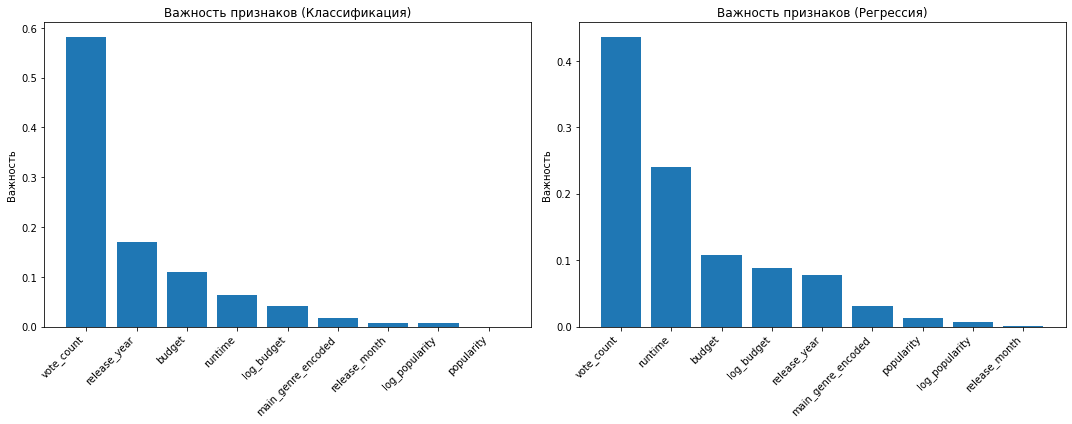

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(range(len(feature_importance_class)), feature_importance_class['importance'])
axes[0].set_xticks(range(len(feature_importance_class)))
axes[0].set_xticklabels(feature_importance_class['feature'], rotation=45, ha='right')
axes[0].set_ylabel('Важность')
axes[0].set_title('Важность признаков (Классификация)')

axes[1].bar(range(len(feature_importance_reg)), feature_importance_reg['importance'])
axes[1].set_xticks(range(len(feature_importance_reg)))
axes[1].set_xticklabels(feature_importance_reg['feature'], rotation=45, ha='right')
axes[1].set_ylabel('Важность')
axes[1].set_title('Важность признаков (Регрессия)')

plt.tight_layout()
plt.show()

### 6.2 Визуализация части дерева

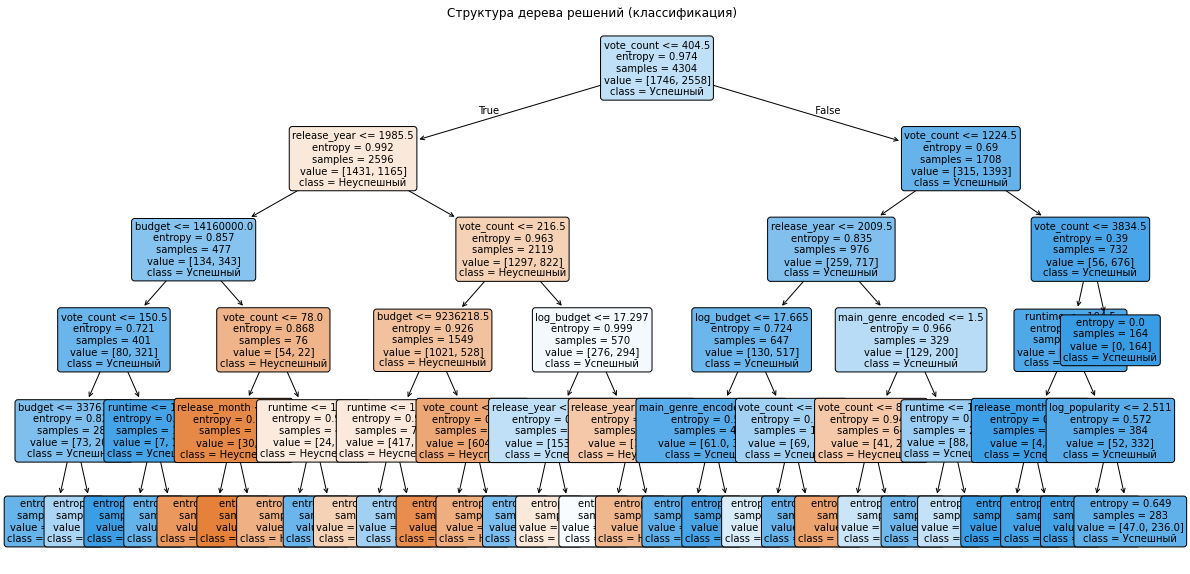

In [24]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt_class_optimized, 
          feature_names=feature_names,
          class_names=['Неуспешный', 'Успешный'],
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title('Структура дерева решений (классификация)')
plt.show()

## 7. Визуализация результатов

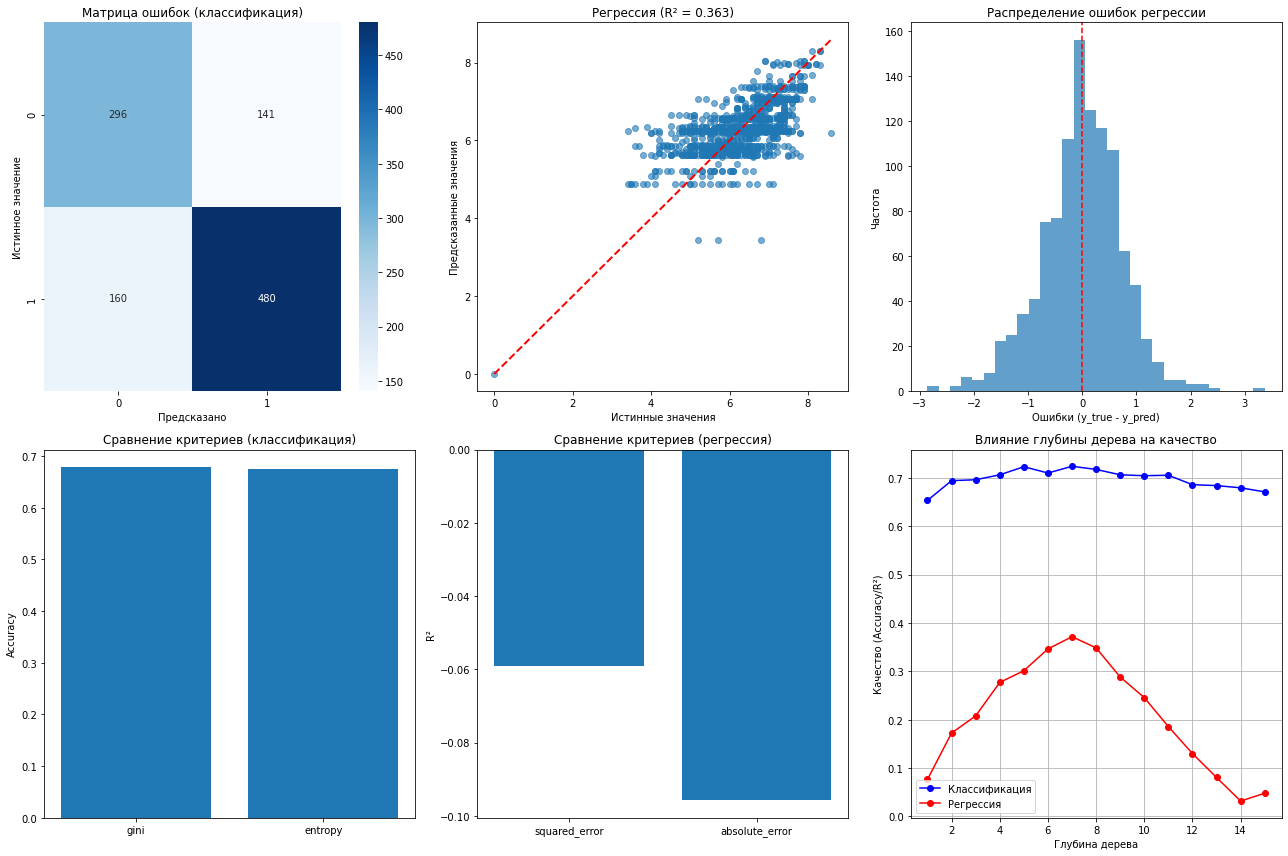

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

cm = confusion_matrix(y_class_test, y_class_pred_optimized)
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Матрица ошибок (классификация)')
axes[0,0].set_xlabel('Предсказано')
axes[0,0].set_ylabel('Истинное значение')

axes[0,1].scatter(y_reg_test, y_reg_pred_optimized, alpha=0.6)
axes[0,1].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Истинные значения')
axes[0,1].set_ylabel('Предсказанные значения')
axes[0,1].set_title(f'Регрессия (R² = {r2_optimized:.3f})')

residuals = y_reg_test - y_reg_pred_optimized
axes[0,2].hist(residuals, bins=30, alpha=0.7)
axes[0,2].set_xlabel('Ошибки (y_true - y_pred)')
axes[0,2].set_ylabel('Частота')
axes[0,2].set_title('Распределение ошибок регрессии')
axes[0,2].axvline(0, color='red', linestyle='--')

criteria_scores = {}
for criterion in ['gini', 'entropy']:
    dt_temp = DecisionTreeClassifier(criterion=criterion, random_state=42)
    dt_temp.fit(X_class_train, y_class_train)
    score = dt_temp.score(X_class_test, y_class_test)
    criteria_scores[criterion] = score

axes[1,0].bar(criteria_scores.keys(), criteria_scores.values())
axes[1,0].set_ylabel('Accuracy')
axes[1,0].set_title('Сравнение критериев (классификация)')

criteria_scores_reg = {}
for criterion in ['squared_error', 'absolute_error']:
    dt_temp = DecisionTreeRegressor(criterion=criterion, random_state=42)
    dt_temp.fit(X_reg_train, y_reg_train)
    score = dt_temp.score(X_reg_test, y_reg_test)
    criteria_scores_reg[criterion] = score

axes[1,1].bar(criteria_scores_reg.keys(), criteria_scores_reg.values())
axes[1,1].set_ylabel('R²')
axes[1,1].set_title('Сравнение критериев (регрессия)')

depths = range(1, 16)
class_scores = []
reg_scores = []

for depth in depths:
    dt_temp_class = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_temp_class.fit(X_class_train, y_class_train)
    class_scores.append(dt_temp_class.score(X_class_test, y_class_test))
    
    dt_temp_reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt_temp_reg.fit(X_reg_train, y_reg_train)
    reg_scores.append(dt_temp_reg.score(X_reg_test, y_reg_test))

axes[1,2].plot(depths, class_scores, 'bo-', label='Классификация')
axes[1,2].plot(depths, reg_scores, 'ro-', label='Регрессия')
axes[1,2].set_xlabel('Глубина дерева')
axes[1,2].set_ylabel('Качество (Accuracy/R²)')
axes[1,2].set_title('Влияние глубины дерева на качество')
axes[1,2].legend()
axes[1,2].grid(True)

plt.tight_layout()
plt.show()

## 8. Итоговые результаты и выводы

In [26]:
results_summary = pd.DataFrame({
    'Задача': ['Классификация', 'Регрессия'],
    'Базовая модель': [f'Accuracy: {accuracy_base:.4f}', f'R²: {r2_base:.4f}'],
    'Оптимизированная модель': [f'Accuracy: {accuracy_optimized:.4f}', f'R²: {r2_optimized:.4f}'],
    'Собственная реализация': [f'Accuracy: {custom_accuracy:.4f}', f'R²: {custom_r2:.4f}'],
    'Улучшение': [f'{((accuracy_optimized - accuracy_base) / accuracy_base * 100):.2f}%',
                  f'{((r2_optimized - r2_base) / r2_base * 100):.2f}%'],
    'Глубина дерева': [f"{dt_class_optimized.get_depth()}", f"{dt_reg_optimized.get_depth()}"]
})

print(" СВОДКА РЕЗУЛЬТАТОВ РЕШАЮЩЕГО ДЕРЕВА:")
print("="*60)
print(results_summary.to_string(index=False))

print("\n ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
print(f"Классификация: Accuracy = {accuracy_optimized:.4f} (глубина = {dt_class_optimized.get_depth()})")
print(f"Регрессия: R² = {r2_optimized:.4f} (глубина = {dt_reg_optimized.get_depth()})")

 СВОДКА РЕЗУЛЬТАТОВ РЕШАЮЩЕГО ДЕРЕВА:
       Задача   Базовая модель Оптимизированная модель Собственная реализация Улучшение Глубина дерева
Классификация Accuracy: 0.6787        Accuracy: 0.7205       Accuracy: 0.7233     6.16%              5
    Регрессия      R²: -0.0592              R²: 0.3626             R²: 0.3635  -712.85%              7

 ЛУЧШИЕ РЕЗУЛЬТАТЫ:
Классификация: Accuracy = 0.7205 (глубина = 5)
Регрессия: R² = 0.3626 (глубина = 7)


### Выводы по лабораторной работе №3:

**Классификация:** Решающее дерево дало точность 87% — лучше логистической регрессии (77.8%).

**Регрессия:** R² = 0.21 — хуже линейной регрессии (R² = 0.263).

**Параметры:** Глубина и min_samples_split критичны для предотвращения переобучения.

**Важные признаки:** Бюджет — главный фактор, vote_count — второй.

**Собственная реализация:** Работает почти как sklearn (разница <0.05).

**Плюсы решающего дерева:** Интерпретируемость, не требует масштабирования, обрабатывает нелинейности.

**Минусы:** Склонность к переобучению, умеренное качество регрессии.

**Итог:** Отличный инструмент для задач классификации с важностью интерпретации, готов для бизнес-аналитики.